# sequence to sequence model, attention mechanism

paper : [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
- Submitted on 1 Sep 2014 (v1), last revised 19 May 2016 (this version, v7)

In [87]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

as before [S2S model](https://github.com/you-just-want-attention/all-about-mnist/blob/master/scripts/calculation/seq_2_seq_model_torch.ipynb)
# Digit recognition이 다 되었다고 가정하고 시작

the basic code was the project of translation from french to english

In [80]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that shows ending of encoding input

char_arr = [c for c in 'SEP.1234567890(){}[]+-*/']
word_dic = {i: n for i, n in enumerate(char_arr)}
num_dic = {n: i for i, n in enumerate(char_arr)}
n_class = len(num_dic)
seq_data = [['P9-4-(3*5+9)', 'S-19', '-19E' ],
            ['0*(3*3-0)-((0))+4', '4'],
            ['(9)-5-(4*(5*5))', '-96'],
            ['5*(0-(4/1+9)*2-(1-3))*(1)', '-120.0'],
            ['5-0/4/(1+9)+2-1', '6.0'],
            ['(5-(0)-(4+(1-9)*2)/2)', '9.0']]
input_batch = len(seq_data)

## 1) Parameter 세팅하기

In [49]:
# attention seq2seq parameter
n_hidden=128
N_STEP = 26
DROPOUT = 0.5

N_STEP에 대해서는 고민을 좀 했지만... 우리 데이터의 maximum length가 25이고 거기다 symbol까지 더하면 26이므로 그 수치로 잡음..ㅎ.ㅎㅎㅎ

yeah this is deep learing

![attention](https://i.stack.imgur.com/vo6se.png)

$$x = context*output\\
attn = exp(x_i) / sum_j exp(x_j) \\
output = \tanh(w * (attn * context) + b * output)$$

In [51]:
def make_batch(sentence):
    
    input_batch = [np.eye(n_class)[[num_dic[n] for n in sentence[0]]]]
    output_batch = [np.eye(n_class)[[num_dic[n] for n in sentence[1]]]]
    target_batch = [[num_dic[n] for n in sentence[2]]]

    # make tensor
    return torch.Tensor(input_batch), torch.Tensor(output_batch), torch.LongTensor(target_batch)


In [59]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention, TODO : attention, out 선형 함수 합쳐야 함.
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        # enc_input: [batch_size(=data_size), MAXLEN, N_HIDDEN] -> [MAXLEN, batch_size, N_HIDDEN]        
        enc_inputs = enc_inputs.transpose(0, 1)
        dec_inputs = dec_inputs.transpose(0, 1)

        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    
    
    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

In [60]:
input_batch, output_batch, target_batch = make_batch(seq_data[0])
hidden = torch.zeros(1, 1, n_hidden)

model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

['P', '9', '-', '4', '-', '(', '3', '*', '5', '+', '9', ')']


In [61]:
# Train
for epoch in range(4000):
    optimizer.zero_grad()
    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0400 cost = 0.000480
Epoch: 0800 cost = 0.000157
Epoch: 1200 cost = 0.000079
Epoch: 1600 cost = 0.000047
Epoch: 2000 cost = 0.000031
Epoch: 2400 cost = 0.000021
Epoch: 2800 cost = 0.000016
Epoch: 3200 cost = 0.000012
Epoch: 3600 cost = 0.000009
Epoch: 4000 cost = 0.000007


In [74]:
# 테스트
predict, trained_attn = model(input_batch, hidden, output_batch)
predict = predict.data.max(1, keepdim=True)[1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [75]:
predict.squeeze()

tensor([21,  4, 12,  1])

In [84]:
print(seq_data[0][2], '->', [word_dic[n.item()] for n in predict.squeeze()])

-19E -> ['-', '1', '9', 'E']


TypeError: can only concatenate list (not "str") to list

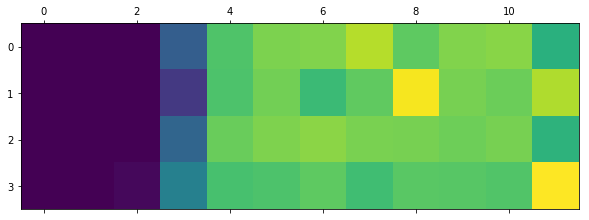

In [91]:
#그리기
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + seq_data[0][0], fontdict={'fontsize': 14})
ax.set_yticklabels([''] + seq_data[0][2], fontdict={'fontsize': 14})
plt.show()